------
# Introdução

> Olá! Seja bem-vindo.
> 
> Quem nunca ficou curioso por tentar prever o valor da gasolina amanhã? Será possível? Esse projeto terá esse objetivo.
> Iremos analisar dados históricos desses valores, mais precisamente um recorte do ano de 2013 até 2020. Analisando possíveis padrões existentes, e por fim modelando uma ferramenta que nos ajude a prever os valores futuros desse produto.
>
> `Links dos Dados Originais:`
> 
> [Série Histórica Combustíveis](https://dados.gov.br/dados/conjuntos-dados/serie-historica-de-precos-de-combustiveis-e-de-glp)
> 
> [IPCA - Inflação](https://brasilindicadores.com.br/ipca)



# Importando Pacotes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import os
import datetime as dt
import time
import scipy
import requests
from bs4 import BeautifulSoup as bs4

# Carregando Dados e criando Funções (Leitura e Ajustes)

In [2]:
def read_data(tipo_produto: str, path: str):
    files_name = os.listdir(path)
    df = pd.DataFrame()
    
    for file in files_name:
        df_temp = pd.read_csv(path + file, sep=';', parse_dates=True, encoding='utf-8', low_memory=False)
        df = pd.concat([df, df_temp])
    
    df = df.drop(columns=['Nome da Rua', 'Numero Rua', 'Complemento', 'Cep', 'Unidade de Medida'])
    nomes_colunas = {
                    'Estado - Sigla':'EstadoSigla',
                    'Municipio':'Municipio',
                    'Revenda':'Revenda',
                    'CNPJ da Revenda':'CNPJRevenda',
                    'Bairro':'Bairro',
                    'Produto':'Produto',
                    'Data da Coleta':'DataColeta',
                    'Valor de Venda':'ValorVenda',
                    'Valor de Compra':'ValorCompra',
                    'Bandeira':'Bandeira'
                     }

    df = df.rename(columns=nomes_colunas)
    df['Produto'] = df['Produto'].str.upper()
    return df.loc[df['Produto']==tipo_produto]

def float_converter(colunas, dataframe):
    for coluna in colunas:
        try:
            dataframe[coluna] = dataframe[coluna].str.replace(',','.').astype(float)
            print(f'{coluna} convertido com sucesso para {column_type}')
        except:
            column_type = type(dataframe[coluna].dtype)
            print(f'Uma excessão ocorreu porque {coluna} é do tipo {column_type}')
            
def add_dates(colunas, dataframe):
    for coluna in colunas:
        dataframe[coluna] = pd.to_datetime(dataframe[coluna],format='mixed')
        dataframe['mes'] = dataframe[coluna].dt.month.astype(int)
        dataframe['ano'] = dataframe[coluna].dt.year.astype(int)
        dataframe['dia'] = dataframe[coluna].dt.day.astype(int)
        
    return 'Datas Adicionadas'

In [3]:
combustiveis = read_data('GASOLINA', path = '/media/jorge/HDD/Python/combustiveis/dados_historicos/')

#Conversões de tipo de dados
float_converter(['ValorCompra','ValorVenda'], combustiveis)
add_dates(['DataColeta'], combustiveis)

Uma excessão ocorreu porque ValorCompra é do tipo <class 'numpy.dtypes.Float64DType'>
ValorVenda convertido com sucesso para <class 'numpy.dtypes.Float64DType'>


'Datas Adicionadas'

In [4]:
colunas_quantitativas = ['ValorVenda', 'ValorCompra']

In [49]:
ipca_hist = pd.read_csv('ipca_historico.csv',
                        index_col='Ano',
                        decimal = ',',
                        dtype={'Jan': float,
                               'Fev': float, 
                               'Mar': float,
                               'Abr': float,
                               'Mai': float,
                               'Jun': float,
                               'Jul': float,
                               'Ago': float,
                               'Set': float,
                               'Out': float,
                               'Nov': float,
                               'Dez': float,
                              }
                       )

In [50]:
ipca_hist.describe()

,Jan,Fev,Mar,Abr,Mai,Jun,Jul,Ago,Set,Out,Nov,Dez,Acumulado no ano
count,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000
mean,0.077709,0.070205,0.066445,0.049618,0.051141,0.056861,0.047323,0.046716,0.051016,0.054452,0.060268,0.065382,2.527398
std,0.138496,0.137034,0.144753,0.087624,0.092386,0.102189,0.077318,0.084658,0.094783,0.095496,0.106781,0.112424,5.587392
min,0.002100,0.001300,0.000700,-0.003100,-0.003800,-0.002300,-0.006800,-0.005100,-0.002900,0.000000,-0.002100,0.000000,0.016600
25%,0.005475,0.004825,0.004300,0.005500,0.003925,0.002200,0.002350,0.002275,0.002550,0.003975,0.003750,0.004950,0.057575
50%,0.008450,0.008800,0.008550,0.007750,0.005600,0.006050,0.009350,0.005150,0.005550,0.007850,0.007700,0.008250,0.083050
75%,0.088975,0.082700,0.062350,0.060325,0.065250,0.074475,0.064800,0.050875,0.051250,0.060275,0.057550,0.080275,1.196000
max,0.675500,0.757300,0.823900,0.426800,0.440300,0.474300,0.307200,0.337100,0.375600,0.397700,0.478200,0.515000,24.771500


# Visão Geral dos Dados

In [7]:
combustiveis.isnull().sum()

Regiao - Sigla          0
EstadoSigla             0
Municipio               0
Revenda                 0
CNPJRevenda             0
Bairro               7407
Produto                 0
DataColeta              0
ValorVenda              0
ValorCompra       1233760
Bandeira                0
mes                     0
ano                     0
dia                     0
dtype: int64

In [8]:
combustiveis[colunas_quantitativas].describe().round(3)

,ValorVenda,ValorCompra
count,2159058.000,925298.000
mean,3.713,3.189
std,0.672,0.627
min,2.229,2.025
25%,3.050,2.564
50%,3.740,3.170
75%,4.259,3.710
max,6.290,5.091


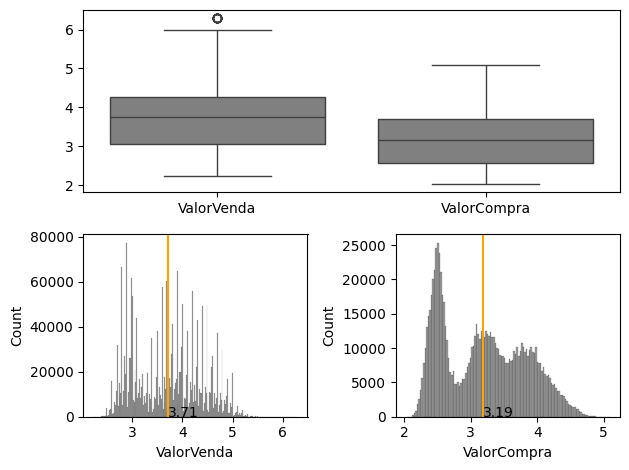

In [22]:
plt.subplot(2, 2, (1, 2))
sb.boxplot(combustiveis[colunas_quantitativas], color = 'gray')

plt.subplot(2, 2, 3)
sb.histplot(combustiveis['ValorVenda'], color = 'gray')
media = combustiveis['ValorVenda'].mean()
plt.axvline(media, color = 'orange')
plt.text(x = media, y = 0, s = round(media, 2)) 
plt.axvline(media, color = 'orange')


plt.subplot(2, 2, 4)
sb.histplot(combustiveis['ValorCompra'], color = 'gray')
media = combustiveis['ValorCompra'].mean()
plt.text(x = media, y = 0, s = round(media, 2)) 
plt.axvline(media, color = 'orange')

plt.tight_layout()
plt.show()

## Distribuição dos Dados - Geral
>Já observamos alguns pontos interessantes.
>- Temos 1.233.760 valores de compra vazios.
>  
>- Temos um pico nos valores a esquerda da nossa distribuição de dados quantitativos (valores mais baixos).
>  
>- Temos uma amplitude alta nesse contexto, variamos de valores de compra de `R$2,50` para `R$5,09`.
>  
>- Essa variação faz com que **não possamos tomar a `média geral` como um boa representação dos nossos dados. Pelo menos não no cenário geral**
>
>Vamos estratificar essas distribuição em busca de outras visualizações.

# Visualização da Série Temporal

### Evolução Geral

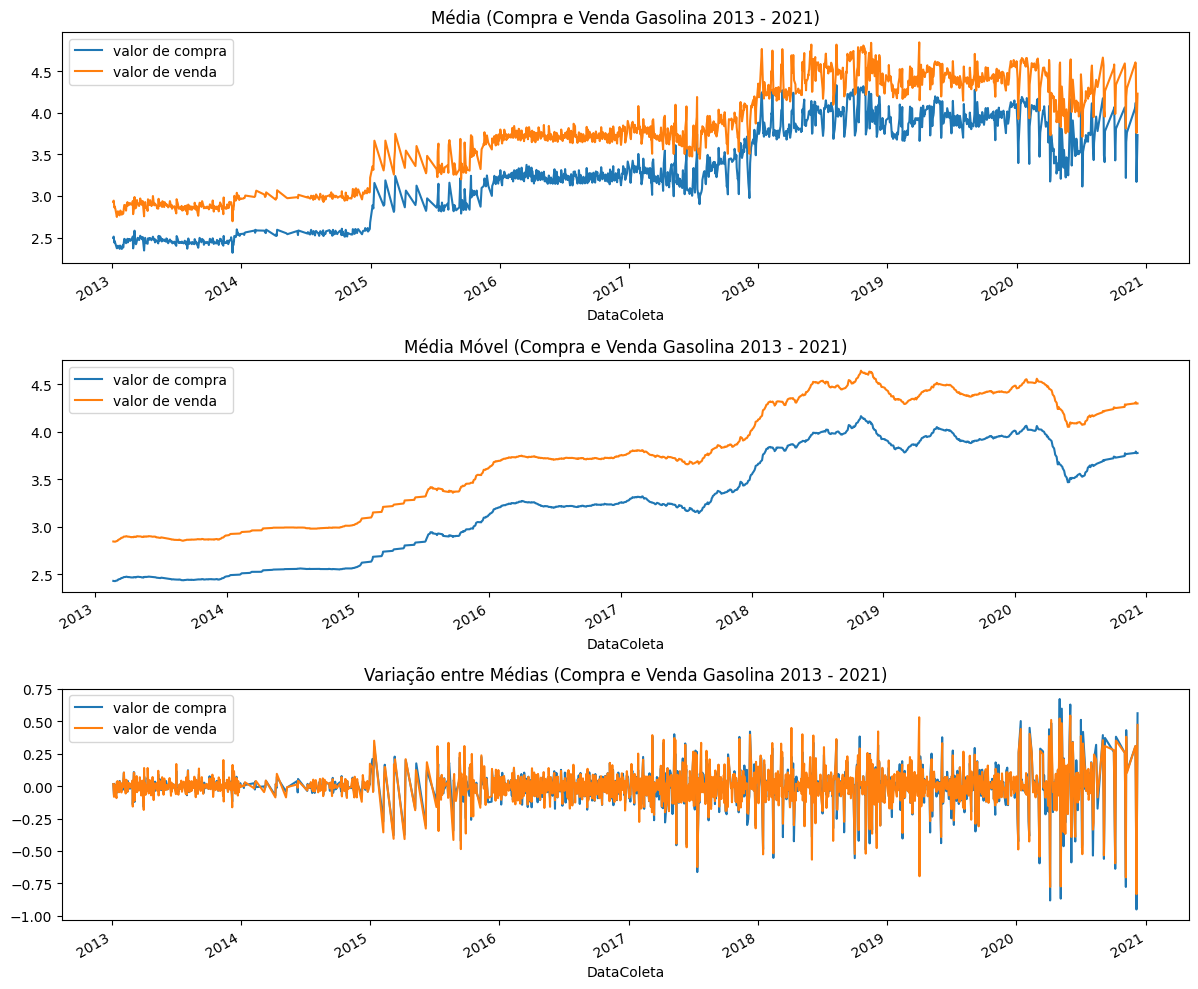

In [29]:
media_compra = combustiveis.dropna(axis = 0).groupby(by = 'DataColeta')['ValorCompra'].mean()
media_venda = combustiveis.dropna(axis = 0).groupby(by = 'DataColeta')['ValorVenda'].mean()

num_rows = 3
num_col = 1

plt.figure(figsize = (12, 10))

plt.subplot(num_rows, num_col, 1)
plt.title('Média (Compra e Venda Gasolina 2013 - 2021)')
media_compra.plot(label = 'valor de compra')
media_venda.plot(label = 'valor de venda')
plt.legend()

plt.subplot(num_rows, num_col ,2)
plt.title('Média Móvel (Compra e Venda Gasolina 2013 - 2021)')
media_compra.rolling(30).mean().plot(label = 'valor de compra')
media_venda.rolling(30).mean().plot(label = 'valor de venda')
plt.legend()

plt.subplot(num_rows, num_col, 3)
plt.title('Variação entre Médias (Compra e Venda Gasolina 2013 - 2021)')
media_compra.diff().plot(label = 'valor de compra')
media_venda.diff().plot(label = 'valor de venda')
plt.legend()

plt.tight_layout()
plt.savefig('analise_serie.png', dpi=150)
plt.show()


> - Os `valores de venda` acompanham de maneira quase idêntica a evolução dos `valores de compra`, o que indica que esse produto tende a seguir uma margem fixa de lucro. Isso pode nos auxiliar a lidar com os valores nulos encontrados anteriormente.
>
> - Até 2014 os números pareciam não sofrer grandes variações, em 2015 começamos a enxergar tendências de aumento, em 2016 o aumento se mostra mais e mais significativo.
>
> - Temos uma queda acentuada na metade do ano 2020.

### Evolução por estado (UF)

In [42]:
media_compra = combustiveis.dropna(axis = 0).groupby(by = ['DataColeta', 'EstadoSigla'])['ValorCompra'].mean()
media_venda = combustiveis.dropna(axis = 0).groupby(by = ['DataColeta', 'EstadoSigla'])['ValorVenda'].mean()

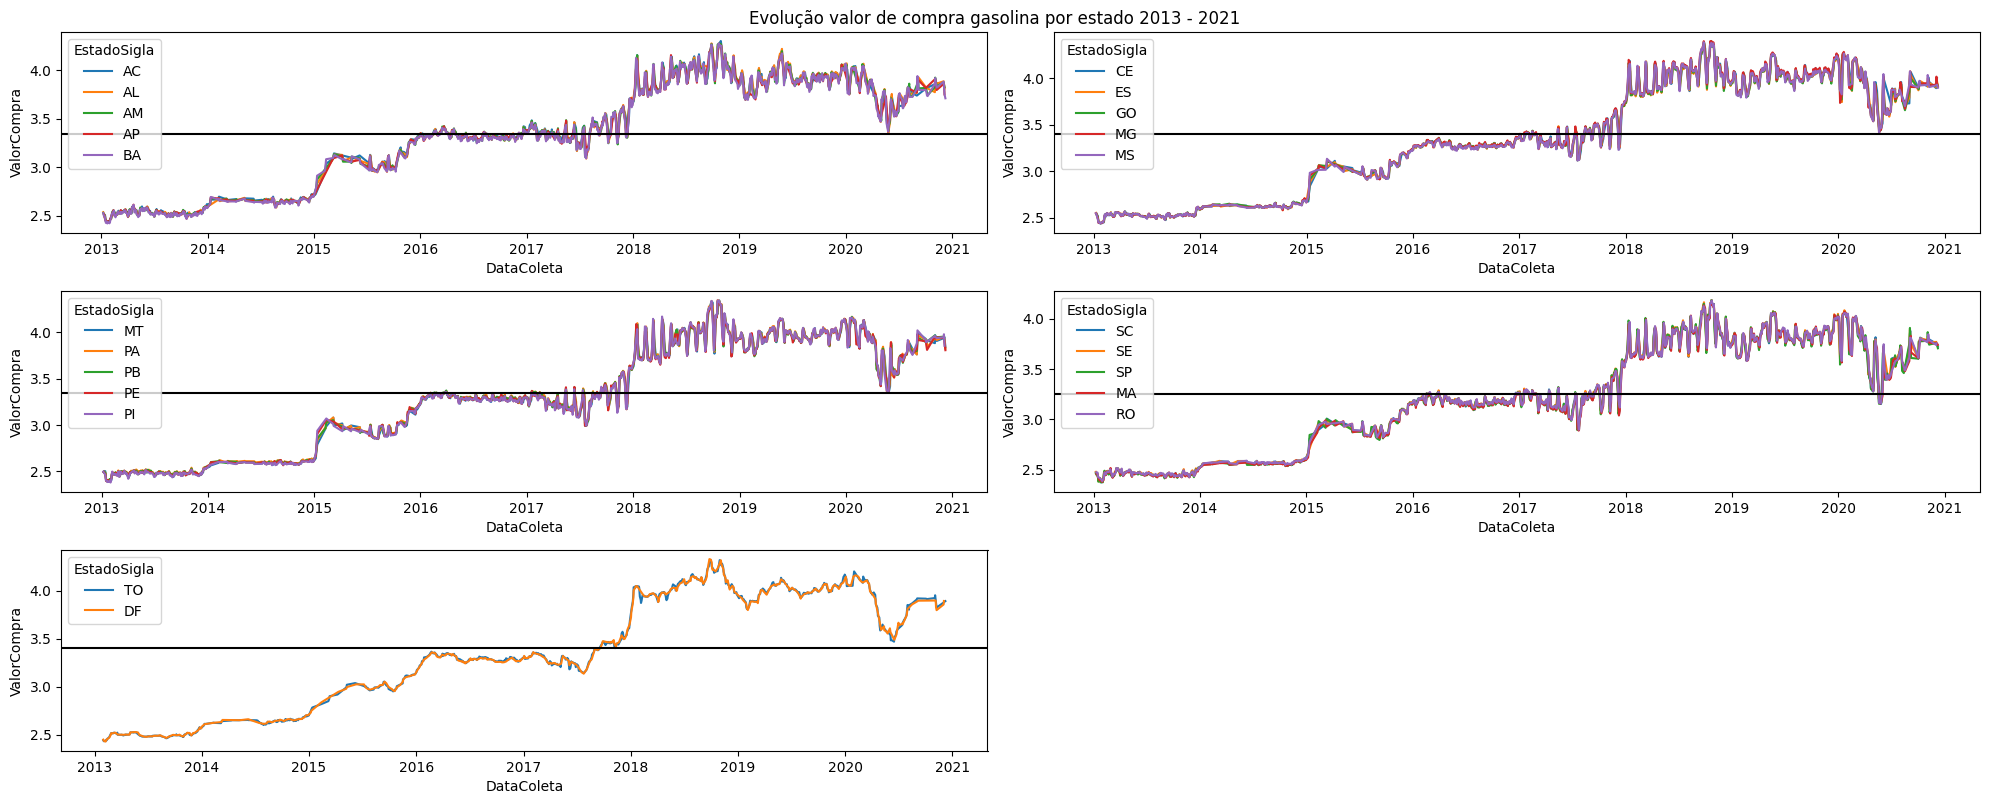

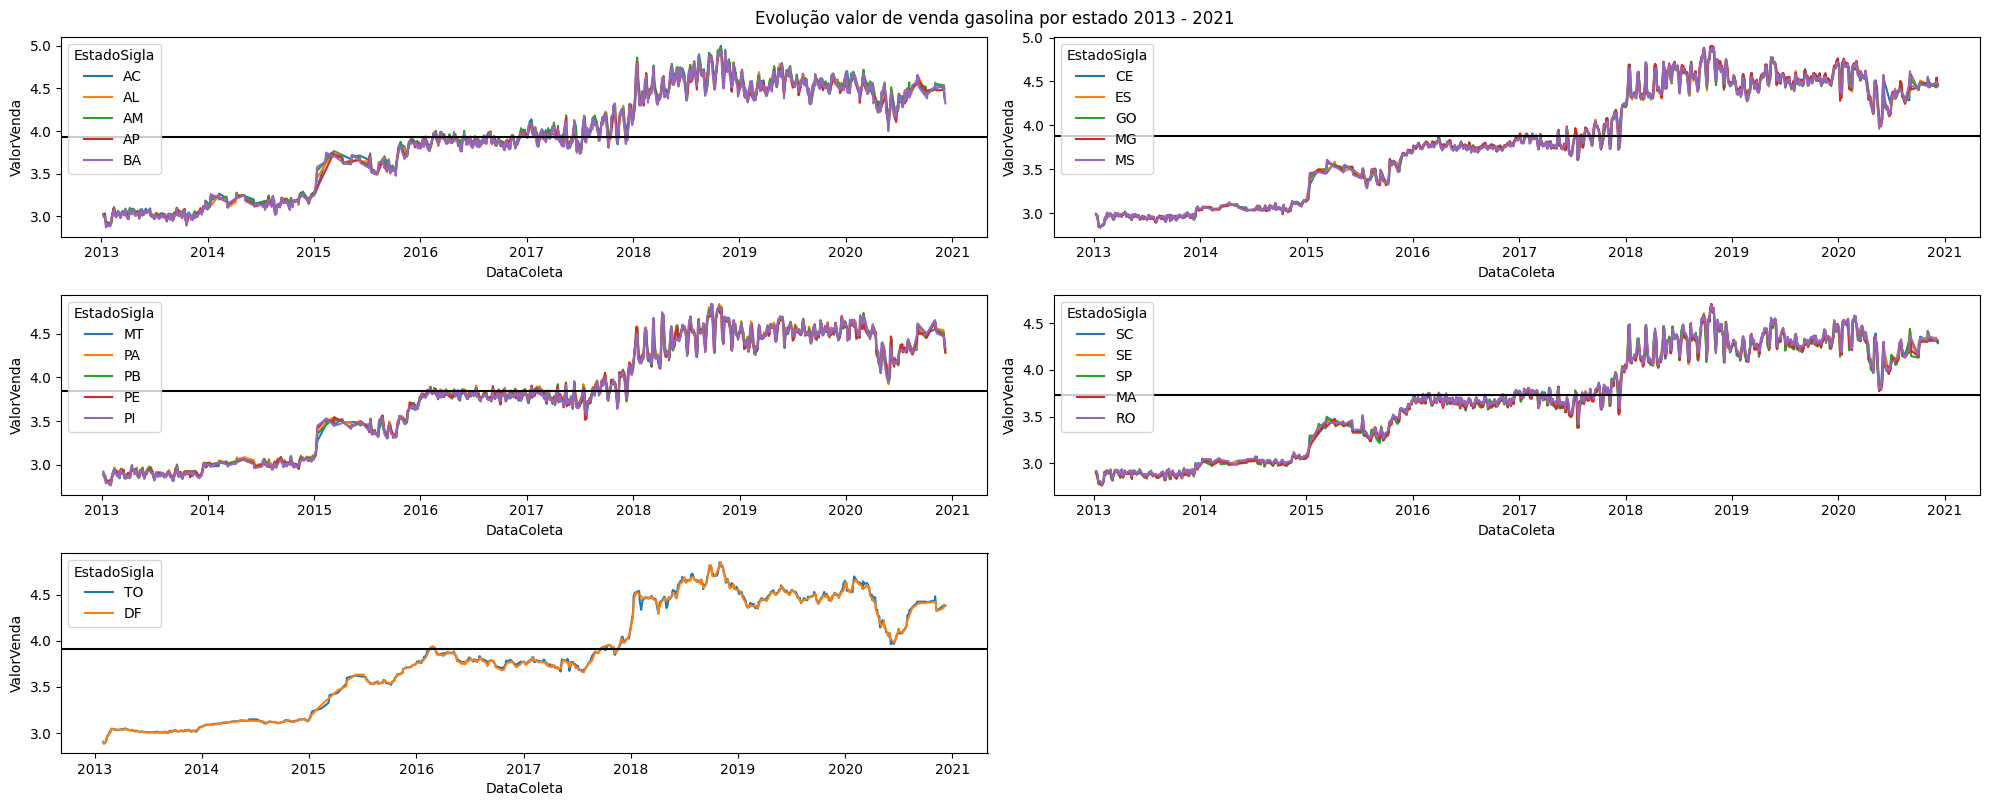

In [45]:
#Pegando 27 Estados
estados = list(media_compra.index.get_level_values(1).unique()) 

plt.figure(figsize = (20, 13)).suptitle('Evolução valor de compra gasolina por estado 2013 - 2021')
mv_av_periods = 15

plt.subplot(5, 2, 1)
data_sliced = media_compra.loc[media_compra.index.get_level_values(1).isin(estados[0:5])]
sb.lineplot(x = data_sliced.index.get_level_values(0),
            y = data_sliced.rolling(mv_av_periods).mean(),
            hue = data_sliced.index.get_level_values(1)
           )
plt.axhline(data_sliced.mean(), color = 'black')


plt.subplot(5, 2, 2)
data_sliced = media_compra.loc[media_compra.index.get_level_values(1).isin(estados[5:10])]
sb.lineplot(x = data_sliced.index.get_level_values(0),
            y = data_sliced.rolling(mv_av_periods).mean(),
            hue = data_sliced.index.get_level_values(1)
           )
plt.axhline(data_sliced.mean(), color = 'black')


plt.subplot(5, 2, 3)
data_sliced = media_compra.loc[media_compra.index.get_level_values(1).isin(estados[10:15])]
sb.lineplot(x = data_sliced.index.get_level_values(0),
            y = data_sliced.rolling(mv_av_periods).mean(),
            hue = data_sliced.index.get_level_values(1)
           )
plt.axhline(data_sliced.mean(), color = 'black')


plt.subplot(5, 2, 4)
data_sliced = media_compra.loc[media_compra.index.get_level_values(1).isin(estados[20:25])]
sb.lineplot(x = data_sliced.index.get_level_values(0),
            y = data_sliced.rolling(mv_av_periods).mean(),
            hue = data_sliced.index.get_level_values(1)
           )
plt.axhline(data_sliced.mean(), color = 'black')


plt.subplot(5, 2, 5)
data_sliced = media_compra.loc[media_compra.index.get_level_values(1).isin(estados[25:30])]
sb.lineplot(x = data_sliced.index.get_level_values(0),
            y = data_sliced.rolling(mv_av_periods).mean(),
            hue = data_sliced.index.get_level_values(1)
           )
plt.axhline(data_sliced.mean(), color = 'black')

plt.tight_layout()
plt.savefig('evolução_compra_por_estado.png', dpi = 150)
plt.show()





plt.figure(figsize = (20, 13)).suptitle('Evolução valor de venda gasolina por estado 2013 - 2021')
mv_av_periods = 15

plt.subplot(5, 2, 1)
data_sliced = media_venda.loc[media_venda.index.get_level_values(1).isin(estados[0:5])]
sb.lineplot(x = data_sliced.index.get_level_values(0),
            y = data_sliced.rolling(mv_av_periods).mean(),
            hue = data_sliced.index.get_level_values(1)
           )
plt.axhline(data_sliced.mean(), color = 'black')


plt.subplot(5, 2, 2)
data_sliced = media_venda.loc[media_venda.index.get_level_values(1).isin(estados[5:10])]
sb.lineplot(x = data_sliced.index.get_level_values(0),
            y = data_sliced.rolling(mv_av_periods).mean(),
            hue = data_sliced.index.get_level_values(1)
           )
plt.axhline(data_sliced.mean(), color = 'black')


plt.subplot(5, 2, 3)
data_sliced = media_venda.loc[media_venda.index.get_level_values(1).isin(estados[10:15])]
sb.lineplot(x = data_sliced.index.get_level_values(0),
            y = data_sliced.rolling(mv_av_periods).mean(),
            hue = data_sliced.index.get_level_values(1)
           )
plt.axhline(data_sliced.mean(), color = 'black')


plt.subplot(5, 2, 4)
data_sliced = media_venda.loc[media_venda.index.get_level_values(1).isin(estados[20:25])]
sb.lineplot(x = data_sliced.index.get_level_values(0),
            y = data_sliced.rolling(mv_av_periods).mean(),
            hue = data_sliced.index.get_level_values(1)
           )
plt.axhline(data_sliced.mean(), color = 'black')


plt.subplot(5, 2, 5)
data_sliced = media_venda.loc[media_venda.index.get_level_values(1).isin(estados[25:30])]
sb.lineplot(x = data_sliced.index.get_level_values(0),
            y = data_sliced.rolling(mv_av_periods).mean(),
            hue = data_sliced.index.get_level_values(1)
           )
plt.axhline(data_sliced.mean(), color = 'black')

plt.tight_layout()
plt.savefig('evolução_venda_por_estado.png', dpi = 150)
plt.show()

> - Notou que o formato de todos os gráficos é muito semelhante? Isso é um forte de indício que esses valores não são fortemente influênciados pelo estado, mas sim pelo passagem to tempo em si, pois a evolução vista é praticamente a mesma observado quando analisamos todos os estados agrupados

### Evolução por bandeira (Fornecedor)


In [46]:
media_compra = combustiveis.dropna(axis = 0).groupby(by = ['DataColeta', 'Bandeira'])['ValorCompra'].mean()
media_venda = combustiveis.dropna(axis = 0).groupby(by = ['DataColeta', 'Bandeira'])['ValorVenda'].mean()

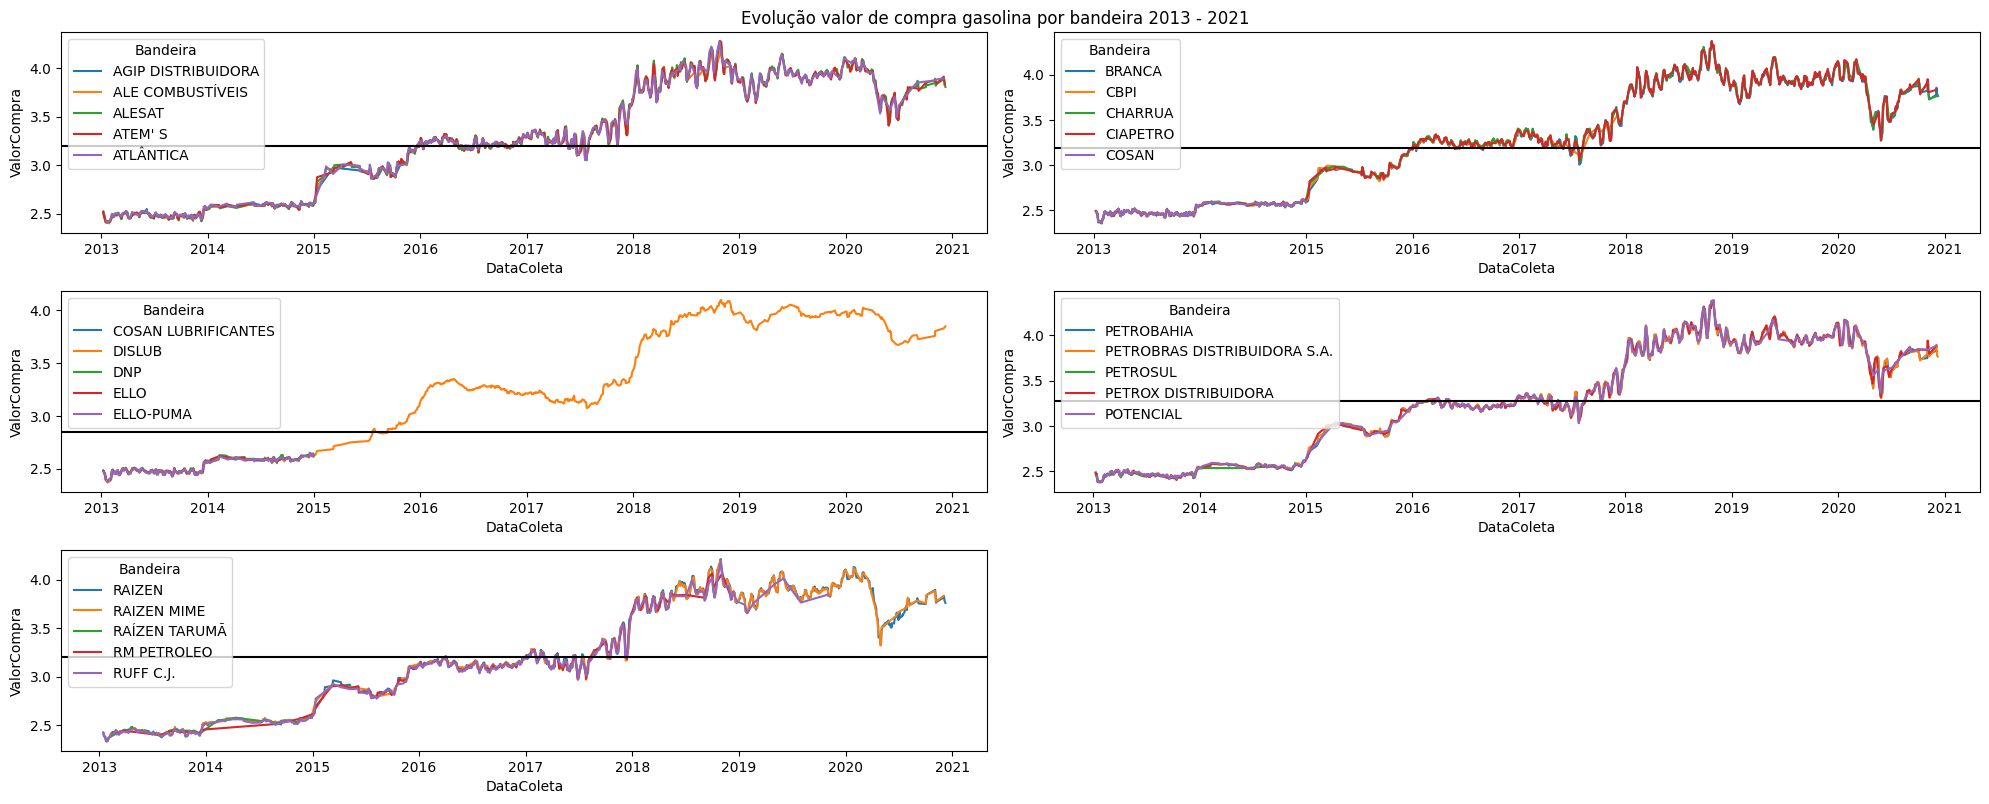

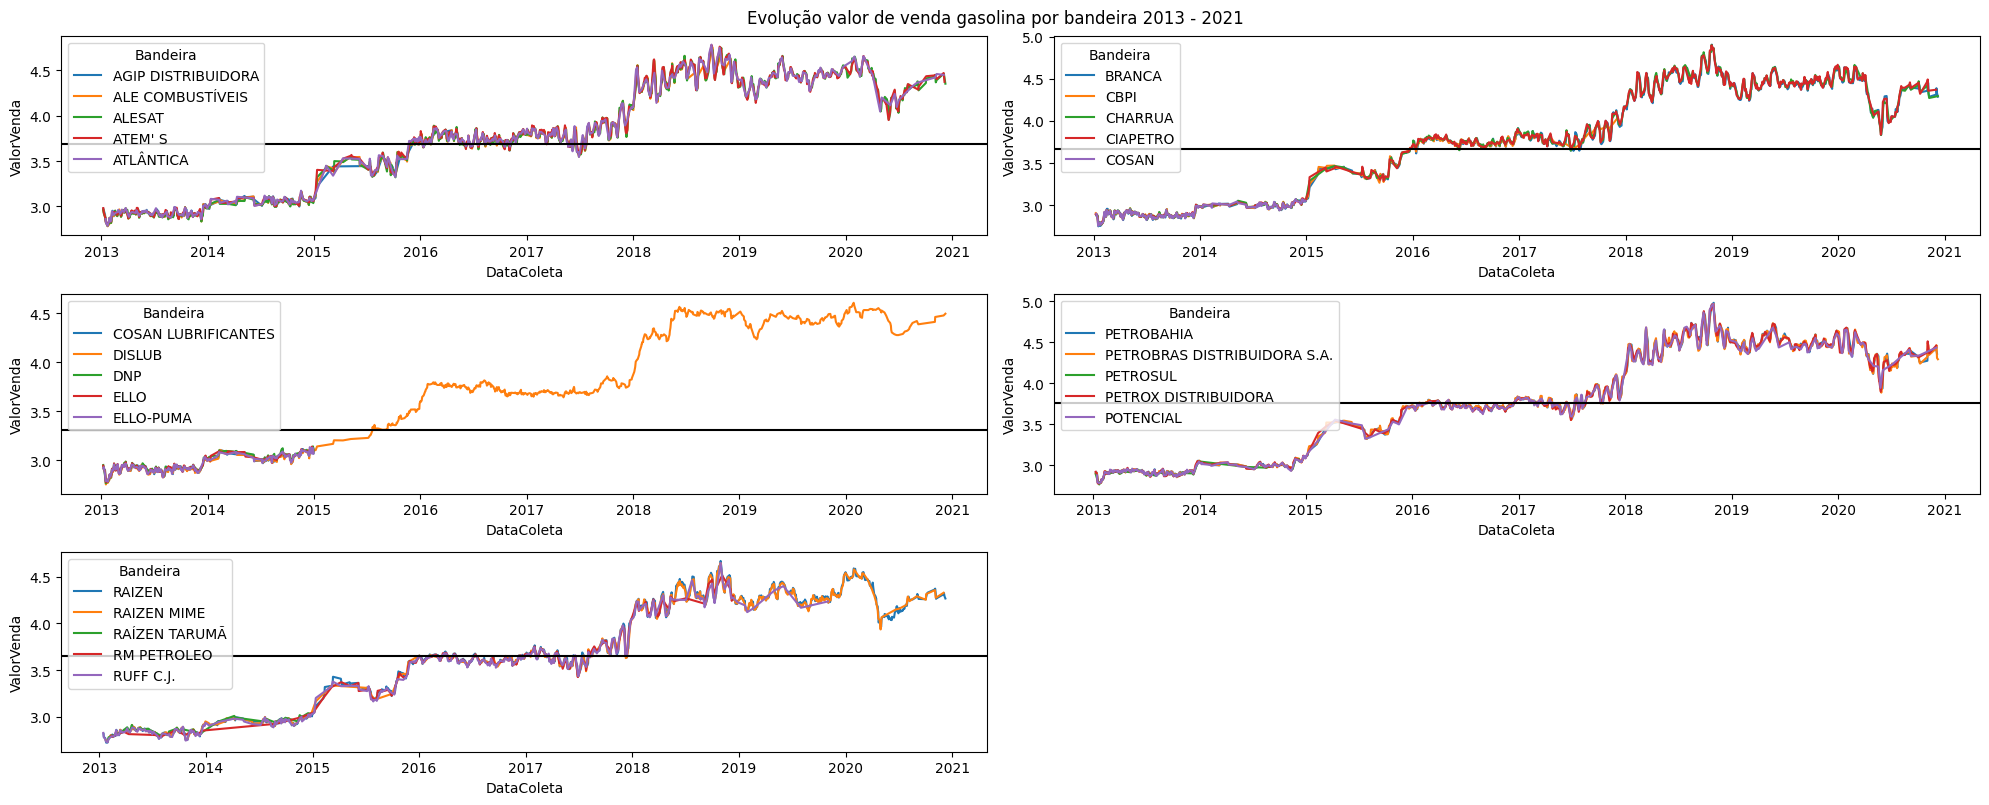

In [47]:
bandeiras = list(media_compra.index.get_level_values(1).unique()) 

plt.figure(figsize = (20, 13)).suptitle('Evolução valor de compra gasolina por bandeira 2013 - 2021')
mv_av_periods = 15

plt.subplot(5, 2, 1)
data_sliced = media_compra.loc[media_compra.index.get_level_values(1).isin(bandeiras[0:5])]
sb.lineplot(x = data_sliced.index.get_level_values(0),
            y = data_sliced.rolling(mv_av_periods).mean(),
            hue = data_sliced.index.get_level_values(1)
           )
plt.axhline(data_sliced.mean(), color = 'black')


plt.subplot(5, 2, 2)
data_sliced = media_compra.loc[media_compra.index.get_level_values(1).isin(bandeiras[5:10])]
sb.lineplot(x = data_sliced.index.get_level_values(0),
            y = data_sliced.rolling(mv_av_periods).mean(),
            hue = data_sliced.index.get_level_values(1)
           )
plt.axhline(data_sliced.mean(), color = 'black')


plt.subplot(5, 2, 3)
data_sliced = media_compra.loc[media_compra.index.get_level_values(1).isin(bandeiras[10:15])]
sb.lineplot(x = data_sliced.index.get_level_values(0),
            y = data_sliced.rolling(mv_av_periods).mean(),
            hue = data_sliced.index.get_level_values(1)
           )
plt.axhline(data_sliced.mean(), color = 'black')


plt.subplot(5, 2, 4)
data_sliced = media_compra.loc[media_compra.index.get_level_values(1).isin(bandeiras[20:25])]
sb.lineplot(x = data_sliced.index.get_level_values(0),
            y = data_sliced.rolling(mv_av_periods).mean(),
            hue = data_sliced.index.get_level_values(1)
           )
plt.axhline(data_sliced.mean(), color = 'black')


plt.subplot(5, 2, 5)
data_sliced = media_compra.loc[media_compra.index.get_level_values(1).isin(bandeiras[25:30])]
sb.lineplot(x = data_sliced.index.get_level_values(0),
            y = data_sliced.rolling(mv_av_periods).mean(),
            hue = data_sliced.index.get_level_values(1)
           )
plt.axhline(data_sliced.mean(), color = 'black')

plt.tight_layout()
plt.savefig('evolução_compra_por_bandeira.png', dpi = 150)
plt.show()





plt.figure(figsize = (20, 13)).suptitle('Evolução valor de venda gasolina por bandeira 2013 - 2021')
mv_av_periods = 15

plt.subplot(5, 2, 1)
data_sliced = media_venda.loc[media_venda.index.get_level_values(1).isin(bandeiras[0:5])]
sb.lineplot(x = data_sliced.index.get_level_values(0),
            y = data_sliced.rolling(mv_av_periods).mean(),
            hue = data_sliced.index.get_level_values(1)
           )
plt.axhline(data_sliced.mean(), color = 'black')


plt.subplot(5, 2, 2)
data_sliced = media_venda.loc[media_venda.index.get_level_values(1).isin(bandeiras[5:10])]
sb.lineplot(x = data_sliced.index.get_level_values(0),
            y = data_sliced.rolling(mv_av_periods).mean(),
            hue = data_sliced.index.get_level_values(1)
           )
plt.axhline(data_sliced.mean(), color = 'black')


plt.subplot(5, 2, 3)
data_sliced = media_venda.loc[media_venda.index.get_level_values(1).isin(bandeiras[10:15])]
sb.lineplot(x = data_sliced.index.get_level_values(0),
            y = data_sliced.rolling(mv_av_periods).mean(),
            hue = data_sliced.index.get_level_values(1)
           )
plt.axhline(data_sliced.mean(), color = 'black')


plt.subplot(5, 2, 4)
data_sliced = media_venda.loc[media_venda.index.get_level_values(1).isin(bandeiras[20:25])]
sb.lineplot(x = data_sliced.index.get_level_values(0),
            y = data_sliced.rolling(mv_av_periods).mean(),
            hue = data_sliced.index.get_level_values(1)
           )
plt.axhline(data_sliced.mean(), color = 'black')


plt.subplot(5, 2, 5)
data_sliced = media_venda.loc[media_venda.index.get_level_values(1).isin(bandeiras[25:30])]
sb.lineplot(x = data_sliced.index.get_level_values(0),
            y = data_sliced.rolling(mv_av_periods).mean(),
            hue = data_sliced.index.get_level_values(1)
           )
plt.axhline(data_sliced.mean(), color = 'black')

plt.tight_layout()
plt.savefig('evolução_venda_por_bandeira.png', dpi = 150)
plt.show()

>-Semelhante a análise por estado, as bandeiras ao longo do tempo não demonstraram diferença significativa entre si.
>
>**-Será que a evolução da inflação (IPCA) foi responsável por esse aumento?**

## Inflanção (IPCA)

In [66]:
media_compra = combustiveis.dropna(axis = 0).groupby(by = 'DataColeta')['ValorCompra'].mean()
media_venda = combustiveis.dropna(axis = 0).groupby(by = 'DataColeta')['ValorVenda'].mean()

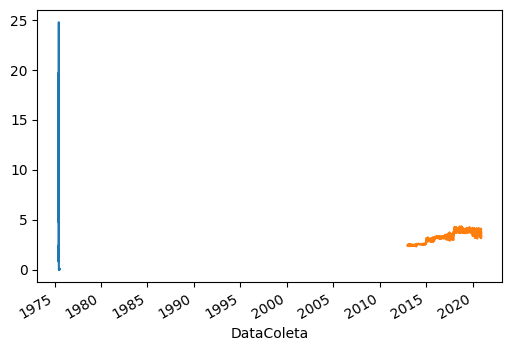

In [67]:
ipca_hist['Acumulado no ano'].plot(figsize = (6, 4))
media_com.plot()
plt.show()

# ARIMA

## Criação Modelo ARIMA

In [6]:
from statsmodels.tsa.arima.model import ARIMA

In [7]:
#Buscando pelo melhor padrão do ARIMA
import warnings
warnings.filterwarnings("ignore")
configs = [(7, 1, 7), (15, 1, 15), (30, 1, 30)]
best_error = 100
for config in configs:
    mod = ARIMA(media_valores, order = config).fit()
    mse_error = (mod.resid ** 2).mean()
    if mse_error < best_error:
        best = mse_error
        print(f'A config {config} é a melhor até agora.\ncom o MSE de {round(mse_error, 5)}')
        best_config = config

A config (7, 1, 7) é a melhor até agora.
com o MSE de 0.02013
A config (15, 1, 15) é a melhor até agora.
com o MSE de 0.01898
A config (30, 1, 30) é a melhor até agora.
com o MSE de 0.01889


In [8]:
#Separando Treino (Train) e Teste (Test)
train_size = int(((2/3) * len(media_valores)))
train_data = media_valores[:train_size]
test_data = media_valores[train_size:]


#Gerando Parâmetros do Modelo
arima_model_train_set = ARIMA(train_data, order = best_config).fit()

model_params = arima_model_train_set.params

## Avaliando Modelo nos Dados de Teste

In [9]:
arima_model_test_set = ARIMA(test_data, order = best_config).fit(model_params)

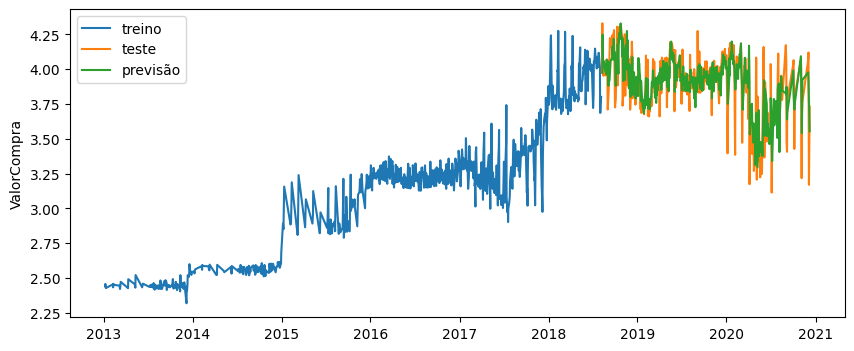

In [10]:
plt.figure(figsize=(10,4))
plt.ylabel('ValorCompra')
plt.plot(train_data, label = 'treino')
plt.plot(test_data, label = 'teste')
plt.plot(arima_model_test_set.predict()[1:], label ='previsão')
plt.legend()

In [12]:
previsao = arima_model_test_set.predict()[1:]

df_validacao = pd.DataFrame(test_data)
df_validacao['previsao'] = previsao
df_validacao.dropna(axis=0, inplace=True)
df_validacao['dif'] = df_validacao.previsao - df_validacao.ValorCompra
df_validacao

,ValorCompra,previsao,dif
DataColeta,,,
2018-08-10,4.330170,3.974255,-0.355915
2018-08-11,4.077916,4.248218,0.170302
2018-08-13,3.957230,4.029093,0.071863
2018-08-14,3.980222,4.022395,0.042173
2018-08-15,3.953252,4.059598,0.106346
...,...,...,...
2020-11-08,3.761795,3.922044,0.160249
2020-12-02,4.068060,3.977969,-0.090092
2020-12-03,4.120311,3.928479,-0.191832


In [13]:
import sklearn.metrics as metrics    

In [14]:
metrics.mean_absolute_percentage_error(df_validacao.ValorCompra, df_validacao.previsao) * 100

2.7299440037828573

In [15]:
metrics.mean_absolute_error(df_validacao.ValorCompra, df_validacao.previsao)

0.10376470192087169

In [16]:
metrics.mean_squared_error(df_validacao.ValorCompra, df_validacao.previsao)

0.022331136934380304

# Testando com Novos Dados

In [17]:
novos_dados = read_data('GASOLINA', path = '/media/jorge/HDD/Python/combustiveis/dados_teste/')
float_converter(['ValorCompra','ValorVenda'], novos_dados)
add_dates(['DataColeta'], novos_dados)

Uma excessão ocorreu porque ValorCompra é do tipo <class 'numpy.dtypes.Float64DType'>
ValorVenda convertido com sucesso para <class 'numpy.dtypes.Float64DType'>


'Datas Adicionadas'

In [18]:
#Dados com problema, Valores de Compra nomeados como Valores de Venda
novos_dados['ValorCompra'].fillna(novos_dados.ValorVenda - (round(np.random.uniform(0.10, 0.12), 3) * novos_dados.ValorVenda), inplace=True)
novos_dados.describe()

,DataColeta,ValorVenda,ValorCompra,mes,ano,dia
count,228810,228810.000000,228810.000000,228810.000000,228810.0,228810.000000
mean,2022-06-21 19:43:11.792316672,6.317323,5.597148,6.205878,2022.0,15.335357
min,2022-01-02 00:00:00,3.490000,3.092140,1.000000,2022.0,1.000000
25%,2022-03-30 00:00:00,5.390000,4.775540,3.000000,2022.0,7.000000
50%,2022-06-16 00:00:00,6.490000,5.750140,6.000000,2022.0,15.000000
75%,2022-09-02 00:00:00,7.090000,6.281740,9.000000,2022.0,23.000000
max,2022-12-30 00:00:00,8.990000,7.965140,12.000000,2022.0,31.000000
std,NaN,0.988287,0.875622,3.334546,0.0,9.036975


In [19]:
novos_dados = novos_dados.groupby(by='DataColeta')['ValorCompra'].mean()

In [20]:
novos_dados.describe()

count    254.000000
mean       5.437929
std        0.873058
min        4.057880
25%        4.445925
50%        5.784751
75%        6.378047
max        7.124917
Name: ValorCompra, dtype: float64

In [21]:
modelo = ARIMA(novos_dados, order = best_config).fit(model_params)

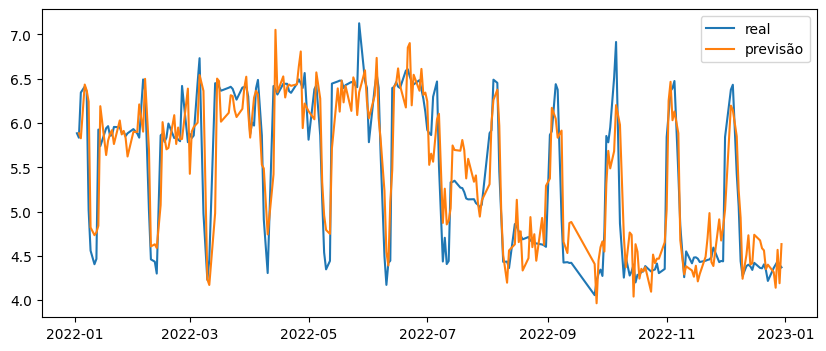

In [22]:
plt.figure(figsize=(10,4))
plt.plot(novos_dados, label= 'real')
plt.plot(modelo.predict()[1:], label='previsão')
plt.legend()

In [23]:
modelo.forecast(1)

254    4.869574
dtype: float64